<a href="https://colab.research.google.com/github/stwind/notebooks/blob/master/cv_seg_matting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pymatting

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import io
import os
import math
import time
import random
import requests
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import cv2
import pymatting as pym
import IPython.display
from fastprogress.fastprogress import progress_bar

## matplotlib style
sns.set('notebook', 'darkgrid', rc={
    'font.family': ['DejaVu Sans'],
    'font.sans-serif': ['Open Sans', 'Arial Unicode MS'],
    'font.size': 12,
    'figure.figsize': (8, 5),
    'grid.linewidth': 1,
    'grid.alpha': 0.5,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.6,
    'legend.handletextpad': 0.2,
    'lines.linewidth': 1,
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'axes.linewidth': 0.5,
    'xtick.labelsize': 11,
    'xtick.major.width': 0.5,
    'ytick.labelsize': 11,
    'ytick.major.width': 0.5,
    'figure.titlesize': 13,
})
plt.style.use("dark_background")

print("Infos:")
print("numpy: {}".format(np.__version__))
print("seaborn: {}".format(sns.__version__))
print("matplotlib: {}".format(mpl.__version__))

Infos:
numpy: 1.19.5
seaborn: 0.11.1
matplotlib: 3.2.2


## Utils

In [4]:
def to_single_rgb(img):
    img = np.asarray(img)
    if len(img.shape) == 4: # take first frame from animations
        return img[0,:,:,:]
    if len(img.shape) == 2: # convert gray to rgb
        return img[:,:,np.newaxis].repeat(3, 2)
    if img.shape[-1] == 4: # drop alpha
        return img[:,:,:3]
    else:
        return img

def imread(url, size=None, mode=None):
    if url.startswith(('http:', 'https:')):
        f = io.BytesIO(requests.get(url).content)
    else:
        f = url
    img = PIL.Image.open(f)
    if size is not None:
        img.thumbnail((size, size), PIL.Image.ANTIALIAS)
    if mode is not None:
        img = img.convert(mode)
    return img

def pil2np(x):
    return np.asarray(x, np.float32) / 255.0

def imshow(img, fmt='png', retina=True, zoom=None):
    if isinstance(img, str):
        IPython.display.display(IPython.display.Image(filename=img, retina=retina))
        return
    
    if len(img.shape) == 1:
        n = len(img)
        side = int(np.sqrt(n))
        if (side * side) != n:
            raise ValueError('input is one-dimensional', img.shape)
        img = img.reshape(side, side)
    if len(img.shape) == 3 and img.shape[-1] == 1:
        img = img.squeeze()
    if img.dtype == np.float32:
        img = img * 255.0
    img = np.uint8(img.clip(0, 255))
    if fmt in ('jpeg', 'jpg'):
        img = to_single_rgb(img)

    data = io.BytesIO()
    PIL.Image.fromarray(img).save(data, fmt)
    height, width = img.shape[:2]
    if zoom is not None:
        width *= zoom
        height *= zoom
    IPython.display.display(IPython.display.Image(data=data.getvalue(),width=width,height=height, retina=retina))

def plt_imshow(img, figsize=(5,5), title=None, cmap=None):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()
    
def minmax(x, axis=None):
    mx = x.max(axis=axis, keepdims=True)
    mn = x.min(axis=axis, keepdims=True)
    return (x - mn) / (mx - mn)

def asfloat(img, dtype=np.float32):
    return img.astype(dtype) / 255.0

def asuint(img, dtype=np.uint8):
    return (img * 255.0).astype(dtype)

def blend(fg, bg, alpha):
    if len(alpha.shape) == 2:
        alpha = alpha[:, :, np.newaxis]
    return alpha * fg + (1 - alpha) * bg

## Data

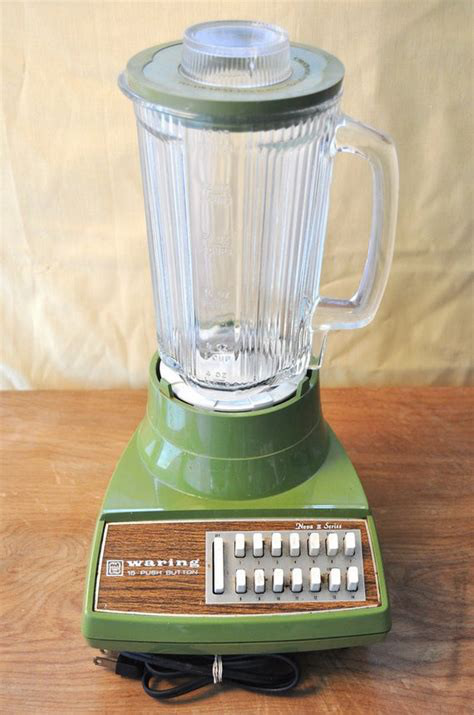

In [5]:
img = np.array(imread("https://miro.medium.com/max/948/1*WRy9aSMxCLVS99kbyUO-mg.jpeg"))

imshow(img)

## Segmentation By Structured Edge Detection

In [22]:
!wget https://github.com/opencv/opencv_extra/raw/4.5.1/testdata/cv/ximgproc/model.yml.gz -O ximgproc.yml.gz && gunzip ximgproc.yml.gz

edgeDetector = cv2.ximgproc.createStructuredEdgeDetection("ximgproc.yml")

--2021-03-01 03:50:33--  https://github.com/opencv/opencv_extra/raw/4.5.1/testdata/cv/ximgproc/model.yml.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/opencv/opencv_extra/4.5.1/testdata/cv/ximgproc/model.yml.gz [following]
--2021-03-01 03:50:33--  https://raw.githubusercontent.com/opencv/opencv_extra/4.5.1/testdata/cv/ximgproc/model.yml.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6390625 (6.1M) [application/octet-stream]
Saving to: ‘ximgproc.yml.gz’

ximgproc.yml.gz     100%[===================>]   6.09M  37.8MB/s    in 0.2s    

2021-03-01 03:50:33 (37.8 MB/s) - ‘ximgproc.yml.gz’ sa

In [23]:
def denoiseSaltPepper(edgeImg):
    lastMedian, median = edgeImg, cv2.medianBlur(edgeImg, 3)
    for i in range(50):
        if np.array_equal(lastMedian, median):
            break
            
        zeroed = np.invert(np.logical_and(median, edgeImg))
        edgeImg[zeroed] = 0

        lastMedian, median = median, cv2.medianBlur(edgeImg, 3)
    return edgeImg

def findLargestContour(contours):
    res, largest = contours[0], cv2.contourArea(contours[0])
    for cnt in contours[1:]:
        area = cv2.contourArea(cnt)
        if area > largest:
            res, largest = cnt, area
    return res


blurred = cv2.GaussianBlur(img, (5, 5), 0)
edges = asuint(edgeDetector.detectEdges(asfloat(blurred)))
edges = denoiseSaltPepper(edges)

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = findLargestContour(contours)
mask = cv2.fillPoly(np.zeros_like(edges, dtype=np.float32), [contour], 1)

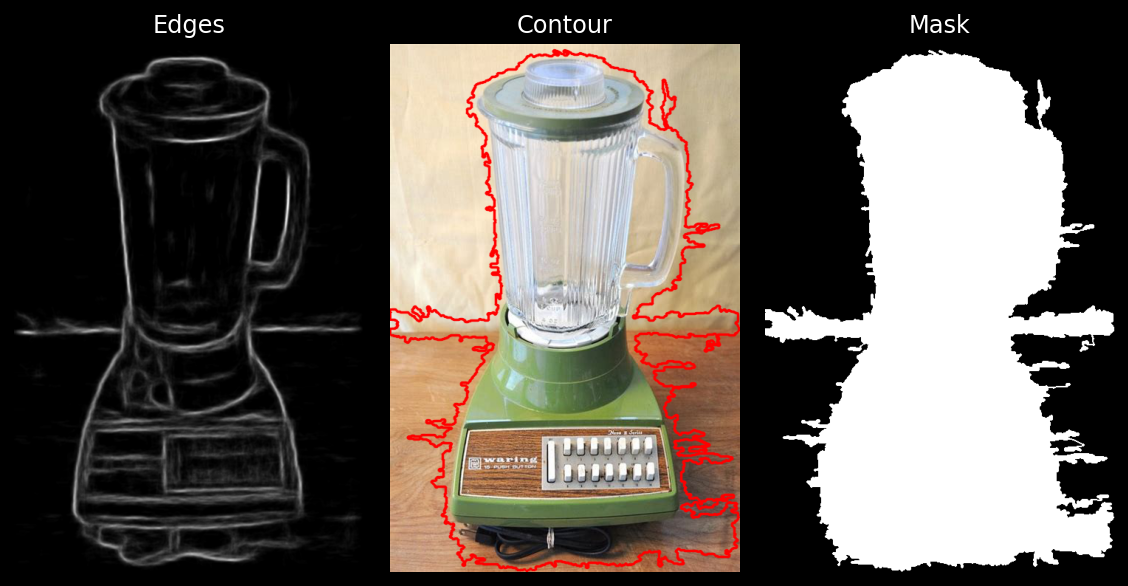

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(8, 5))

ax[0].imshow(edges, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Edges")

ax[1].imshow(cv2.drawContours(np.copy(img), [contour], -1, (255, 0, 0), 2, cv2.LINE_AA, maxLevel=1))
ax[1].set_axis_off()
ax[1].set_title("Contour")

ax[2].imshow(mask, cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Mask")

plt.tight_layout()
plt.show()

## Trimap Generation

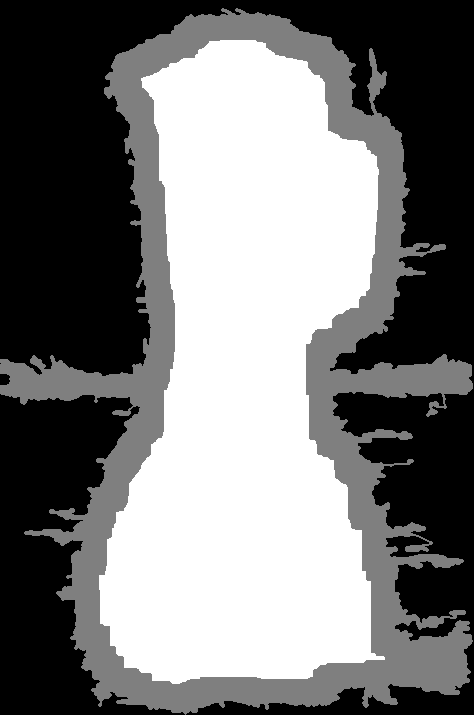

In [15]:
def make_trimap(mask, kernel=None, dilation=10, erosion=10):
    dilated = cv2.dilate(mask, kernel, iterations=dilation)
    eroded = cv2.erode(mask, kernel, iterations=erosion)
    
    trimap = np.zeros_like(mask, np.float32)
    trimap[dilated > 0.0] = 0.5
    trimap[eroded == 1.0] = 1.0
    return trimap


trimap = make_trimap(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (5,5)), dilation=0, erosion=12)
imshow(trimap)

## Matting

### With Grabcut

In [16]:
def make_grabcut_mask(trimap):
    mask = np.zeros_like(trimap, np.uint8)
    mask[trimap == 0] = cv2.GC_BGD
    mask[trimap == 0.5] = cv2.GC_PR_BGD
    mask[trimap == 1.0] = cv2.GC_FGD
    return mask

def rect_of(img):
    return (0, 0, img.shape[0] - 1, img.shape[1] - 1)

mask1 = cv2.grabCut(img, make_grabcut_mask(trimap), rect_of(img), 
                    np.zeros((1, 65), np.float64), 
                    np.zeros((1, 65), np.float64), 
                    5, cv2.GC_INIT_WITH_MASK)[0]

In [17]:
def binarize(mask):
    return cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)[1]

def morph_close(mask, ksize=5):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize,  ksize))
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

def smooth_mask(mask, n=5, ksize=5):
    blurred = cv2.pyrUp(mask)
    for _ in range(n):
        blurred = cv2.medianBlur(blurred, ksize)
    res = cv2.pyrDown(blurred)
    return binarize(res)

alpha = np.where((mask1 == cv2.GC_FGD) | (mask1 == cv2.GC_PR_FGD), 1, 0).astype(np.float32)
alpha = asfloat(smooth_mask(asuint(alpha), n=5, ksize=7))

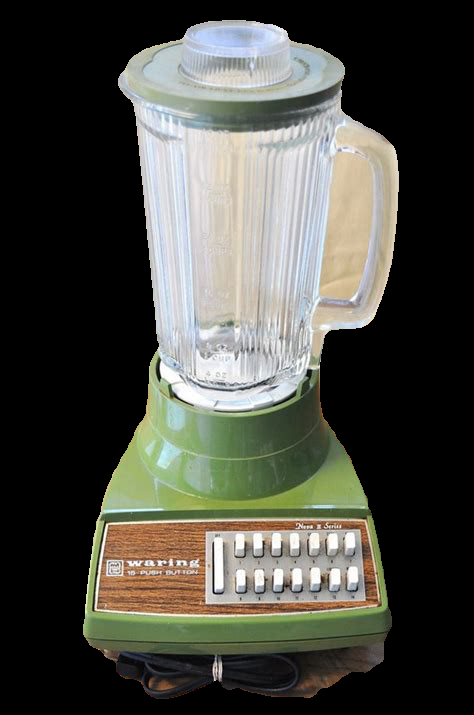

In [18]:
fg = asfloat(img)
cutout = blend(fg, np.zeros_like(img, dtype=np.float32), alpha)

imshow(cutout)

### With PyMatting

In [19]:
alpha = pym.estimate_alpha_cf(asfloat(img, np.float64), trimap.astype(np.float64))

fg = pym.estimate_foreground_cf(asfloat(img), alpha, return_background=False)

In [20]:
alpha1 = binarize(asuint(alpha))
alpha1 = morph_close(alpha1, 9)
alpha1 = smooth_mask(alpha1, ksize=9)
alpha1 = asfloat(alpha1)

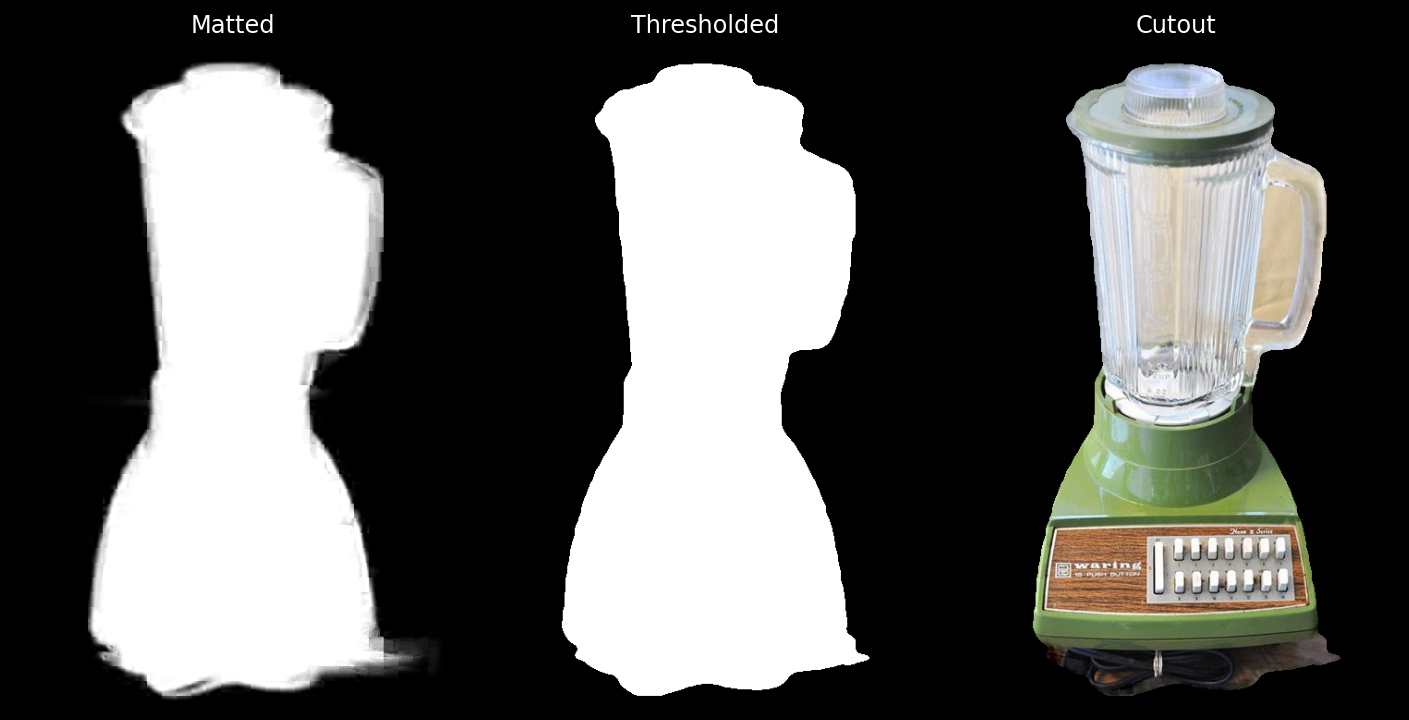

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(alpha, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Matted")

ax[1].imshow(alpha1, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("Thresholded")

ax[2].imshow(blend(fg, np.zeros_like(img), alpha1))
ax[2].set_axis_off()
ax[2].set_title("Cutout")

plt.tight_layout()
plt.show()